# Lab 3
## Motion Capture Clustering

### Team members: Luay Dajani, Dana Geislinger, Chris Morgan, Caroll Rodriguez
##### Github - https://github.com/cdmorgan103/7331DataMiningNoShow

MSDS 7331, 12/02/2018

<br>

# Business Understanding 1

This dataset provides data on captured hand gestures using motion tracking sensors on various users’ gloves. This was done to properly model some of the different movements involved in making 5 different hand gestures (.

From a business perspective, we'd like to model the different locations of the sensors and see if we can properly cluster the different sensors with enough separation relative to their x, y, and z coordinates.

To measure effectiveness of our clustering, we will be examining the Silhouette for the different clustering algorithms we will examine for this dataset. While clustering could be combined with the usage of other modeling techniques, we are primarily going to be examining clustering itself for this particular dataset so we can better understand how much variance actually occurs within the data as a whole and relative to the variance caused by different users and gestures.

Considering that our business user will need to better understand different positioning information for sensor utilization, this will allow stakeholders to have an additional approximation tool for determining what part of the hand is in what location of the area.

<br>

# Data Understanding 1


Data is provided as a CSV file. A header provides the name of each attribute. A question mark '?' is used to indicate a missing value. A record corresponds to a single instant or frame as recorded by the camera system. Data can be found at the link below for reference and a full explanation is available in the table below as well.

https://archive.ics.uci.edu/ml/datasets/Motion+Capture+Hand+Postures#

#### Initial Dataset

| Variable Name  | Data Type | Variable Type         | Description                                                             |
| -------------- | --------- | --------------------- | ----------------------------------------------------------------------- |
| Class          | Nominal  | Identifier            | Classifier for hand gesture made scaled 1 to 5 (1=Fist, 2=Stop, 3=Point1 finger, 4=Point 2 fingers, 5=Grab)                                 |
| User           | Nominal | Identifier            | ID number representing 15 different test users (scaled 0 to 14)| 
| Xi (0-11) | Interval  | Integer        | Measures distance in milimeters on the x axis for the 'i'th sensor (0-11) |
| Yi (0-11) | Interval  | Integer        | Measures distance in milimeters on the y axis for the 'i'th sensor (0-11) |
| Zi (0-11) | Interval  | Integer     | Measures distance in milimeters on the z axis for the 'i'th sensor (0-11) |


<br>

Because our data is 3 dimensional, a transformation of our dataset was required to adequately cluster the data in a 3 dimensional space.


#### Final Dataset
| Variable Name  | Data Type | Variable Type         | Description                                                             |
| -------------- | --------- | --------------------- | ----------------------------------------------------------------------- |
| Class          | Nominal  | Identifier            | Classifier for hand gesture made scaled 1 to 5 (1=Fist, 2=Stop, 3=Point1 finger, 4=Point 2 fingers, 5=Grab)                                 |
| User           | Nominal | Identifier            | ID number representing 15 different test users (scaled 0 to 14)| 
| Sensor    | Nominal  | Identifier       | Sensor identifier (sensors labeled 0-11) |
| X         | Interval  | Integer        | Measures distance in milimeters on the x axis for sensor location |
| Y         | Interval  | Integer        | Measures distance in milimeters on the y axis  for sensor location |
| Z         | Interval  | Integer     | Measures distance in milimeters on the z axis  for sensor location|




Each record is a set. The i-th marker of a given record does not necessarily correspond to the i-th marker of a different record, so it is possible for sensors to be in different positions from run to run.

#### Data preprocessing
To get started, we'll load in our dataset and check the data types

In [1]:
# Import required modules
import numpy as np
import pandas as pd
import math as math
import matplotlib.pyplot as plt
from matplotlib import style
from pprint import pprint
#from IPython.display import display

pd.set_option("display.max_columns",100)

# Load the data into variable 'df'
df = pd.read_csv('https://raw.githubusercontent.com/cdmorgan103/7331DataMiningNoShow/master/LAB3/Postures.csv')

# Get an overview of the raw data
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78096 entries, 0 to 78095
Data columns (total 38 columns):
Class    78096 non-null int64
User     78096 non-null int64
X0       78096 non-null float64
Y0       78096 non-null float64
Z0       78096 non-null float64
X1       78096 non-null float64
Y1       78096 non-null float64
Z1       78096 non-null float64
X2       78096 non-null float64
Y2       78096 non-null float64
Z2       78096 non-null float64
X3       78096 non-null object
Y3       78096 non-null object
Z3       78096 non-null object
X4       78096 non-null object
Y4       78096 non-null object
Z4       78096 non-null object
X5       78096 non-null object
Y5       78096 non-null object
Z5       78096 non-null object
X6       78096 non-null object
Y6       78096 non-null object
Z6       78096 non-null object
X7       78096 non-null object
Y7       78096 non-null object
Z7       78096 non-null object
X8       78096 non-null object
Y8       78096 non-null object
Z8       78096 n

In [2]:
df.head()

,Class,User,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,Z2,X3,Y3,Z3,X4,Y4,Z4,X5,Y5,Z5,X6,Y6,Z6,X7,Y7,Z7,X8,Y8,Z8,X9,Y9,Z9,X10,Y10,Z10,X11,Y11,Z11
0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,54.263880,71.466776,-64.807709,76.895635,42.462500,-72.780545,36.621229,81.680557,-52.919272,85.2322638852917,67.7492195028673,-73.684130041833,59.1885757027887,10.6789364098231,-71.2977813147725,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?
2,1,0,56.527558,72.266609,-61.935252,39.135978,82.538530,-49.596509,79.223743,43.254091,-69.982489,87.4508729469625,68.4008083028339,-70.703990925959,61.5874515532753,11.7799190329758,-68.827417756239,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?
3,1,0,55.849928,72.469064,-62.562788,37.988804,82.631347,-50.606259,78.451526,43.567403,-70.658489,86.8353875680762,68.9079249764243,-71.1383441365739,61.6864271910576,11.7934398850428,-68.88931646056,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?
4,1,0,55.329647,71.707275,-63.688956,36.561863,81.868749,-52.752784,86.320630,68.214645,-72.228461,61.5961571288978,11.2506481750465,-68.9564252307431,77.3872254123912,42.7178334810919,-72.0151462991019,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?


Examination of the data shows that we have a dummy row of 0 that will need to be removed. The data also shows a significant amount of '?' for missing data points, so we will convert these values to NaN as a numeric data type

In [3]:
# we will remove class 0 
df = df[df.Class !=0 ]

#change ? to none to improve data format
df=df.replace({'?': 'NaN'})

#coerces into numeric
df = df.apply(pd.to_numeric, errors='coerce')

In [4]:
# Get an overview of the raw data
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78095 entries, 1 to 78095
Data columns (total 38 columns):
Class    78095 non-null int64
User     78095 non-null int64
X0       78095 non-null float64
Y0       78095 non-null float64
Z0       78095 non-null float64
X1       78095 non-null float64
Y1       78095 non-null float64
Z1       78095 non-null float64
X2       78095 non-null float64
Y2       78095 non-null float64
Z2       78095 non-null float64
X3       77405 non-null float64
Y3       77405 non-null float64
Z3       77405 non-null float64
X4       74975 non-null float64
Y4       74975 non-null float64
Z4       74975 non-null float64
X5       65072 non-null float64
Y5       65072 non-null float64
Z5       65072 non-null float64
X6       52247 non-null float64
Y6       52247 non-null float64
Z6       52247 non-null float64
X7       38943 non-null float64
Y7       38943 non-null float64
Z7       38943 non-null float64
X8       30563 non-null float64
Y8       30563 non-null float64

Only 31 data points appear for the 11th sensor, and are present for one user only. We will delete this as a feature as it does not provide any significant value given lack of data.

In [5]:
del df['X11']
del df['Y11']
del df['Z11']

#### Reformatting the Data for Sensor Clustering

The raw data for this dataset is formatted with each capture being treated as a separate observation. This makes sense if you are classifying the gesture or user, but we are trying to cluster in order to identify which sensor on the glove corresponds to a specific set of coordinates. Therefore, we must stack the data in order to get a new dataset where each observation has only a single X, Y, and Z coordinate, and corresponds to the specific position of an individual sensor module in any given capture. 

The original dataset consists of 78,095 captures with coordinates on up to 11 sensors in any given capture, as well as metadata pertaining to the capture about the user and class the capture was representative of. We will retain this metadata, and also create a new variable that corresponds to the sensor number (0 through 10). However, each coordinate will now be labelled as the raw coordinate number on each cartesian axis (X, Y, Z) regardless of sensor number (as opposed to X0, Y10, Z5, etc. as was the case originally).

At this point, we will now also drop missing datapoints; NaN values in this dataset represent sensors that were obscured or not recorded for some other reason during a capture, and since we are interested in clustering by sensor, it does not further the analysis to include sensor coordinates for which no data was recorded.

In [6]:
# Create a list of dataframes with X, Y, Z coordinates selected for each individual sensor (0-10)
df_coords = [df.loc[:, ['Class', 'User', 'X%d' % i, 'Y%d' %i, 'Z%d' % i]] for i in range(11)]

for i in range(len(df_coords)):
    # NaN values are dropped at this time
    df_coords[i] = df_coords[i].dropna()
    
    # Coordinate variable labels will now be standardized
    df_coords[i].columns = ['Class', 'User', 'X', 'Y', 'Z']
    
    # Sensor number will now be added as a variable 'sensor' to each dataset
    df_coords[i]['Sensor'] = i
    
# Combine datasets into new dataframe: df2
df2 = pd.concat(df_coords, ignore_index=True)

# Reorder columns with metadata columns first
df2 = df2[['Class', 'User', 'Sensor', 'X', 'Y', 'Z']]

With the newly formatted dataset, we now have 612,209 distinct cartesian coordinates with corresponding Sensor, Class, and User metadata.

In [7]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 612209 entries, 0 to 612208
Data columns (total 6 columns):
Class     612209 non-null int64
User      612209 non-null int64
Sensor    612209 non-null int64
X         612209 non-null float64
Y         612209 non-null float64
Z         612209 non-null float64
dtypes: float64(3), int64(3)
memory usage: 28.0 MB


<br>

# Data Understanding 2

In [8]:
import pandas as pd
# Print descriptive info for the unique values for each predictor

print('Class:', list(df2.Class.unique()))
print('User:', list(df2.User.unique()))
#df_User = df.groupby(['User','Class'])['Class'].count() 
df_Class = df2.groupby(['Class', 'User'])['User'].count()

df_Class['total'] = len(df2) #df_User 
print('Total records:', len(df2))


Class: [1, 2, 3, 4, 5]
User: [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Total records: 612209


##### Number of Datapoints per User by Class (Hand Gesture)
Examining the dataset in a stratified manner shows that there is clearly an unequal distribution of hand gestures relative to users and records for each User as a whole. While this is a bit concerning in some extreme cases, it shouldn't drastically change our results and shouldn't require and further stratification or cleaning.

In [9]:
class_color_table = pd.crosstab(index=df2["User"], 
                          columns=df2["Class"])

class_color_table


Class,1,2,3,4,5
User,,,,,
0,8998,16425,9782,11786,20274
1,6369,8184,5391,4754,10733
2,5987,8876,3605,4738,10806
4,114,597,612,965,0
5,4604,10841,6471,8204,11819
6,5016,10582,5318,6168,11702
7,432,1016,806,1033,0
8,6450,15242,9724,8603,12984
9,4560,9201,5421,7495,8305


The chart below show the distribution of data points by user and hand gestures. Users 4 & 7 have the lowest number of data points. User 10 had the most total of datapoints recorded in total.

In [10]:
class_color_table.plot(kind="bar", 
                 figsize=(8,8),
                 stacked=True)


This is a more detailed look at each Class and User combination displaying the number of datapoints. This just further iterates the unequal distribution in parts of our data.

In [11]:
del df_Class['total']
#plot and format bar chart
plt.figure(figsize=(16,5), dpi=80)
_ = df_Class.plot(kind='bar')
#plt.barh(df_neighborhood, width=0.4, height=0.4, align='center', alpha=0.4)

### Interactive Plotting of User/Class Combinations

In [12]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode
import pandas as pd
import numpy as np

# Set up plotly API key
plotly.tools.set_credentials_file(username='danageis', api_key='0NAcrzM8YksRAT3uyEZ7')

# Enable offline plots (embed into ipynb)
init_notebook_mode(connected=True)

# Define list of possible users
possible_users = set(df.User.unique())

# Define dictionary of all possible user/class combinations (which ones took pictures of which)
possible_classes = {usr: set(df.where(df.User == usr).Class.dropna().unique()) for usr in possible_users}

# Define functions to create 3D-interactive plots of each user/position combo
def parse_coords(cls=1, usr=1):
    """ Helper function: return all coords for specified User and Class
    
    cls (int): Class (defaults to 1)
    usr (int): User (defaults to 1)
    
    Ret (dict): {dimension (str): coordinates (pd.Series)}
    """
    dims = ['X', 'Y', 'Z']
    fill = lambda suffix: [suffix + str(i) for i in range(1,11)]
    cols = {col: fill(col) for col in dims}
    coords = {dim: df[cols[dim]].where(df.User == usr).where(df.Class == cls).stack() for dim in dims}
    return coords

def plot_3d(cls=1, usr=1, title=None, allpts=False, clusters=np.array([0])):
    """ Return 3D interactive plot for given coordinates set (single user/sign combos)
    
    cls (int): Class (defaults to 1)
    usr (int): User (defaults to 1)
    title (str): Title of the plot (defaults to "User {usr} Position {cls}")
    allpts (bool): Whether or not this is meant to cluster all points in the dataset (df2)
        All 600k+ points is too many to plot interactively; this will sample 20,000 points randomly and graph them
    clusters (np.array): Clusters to use for color-coding (only valid for allpts at this time)
    
    Ret (plotly.graph_objs.Scatter3d figure object)
    """
    
    # Make sure user/class designation is valid
    if not usr in possible_users:
        return "ERROR: User %d does not have any data. Try again with a different user specified." % usr
    elif not cls in possible_classes[usr]:
        return "ERROR: User %d does not have any data for Class %d. Try again with a different class specified." % (usr, cls)
    
    # Process points to draw
    if allpts:
        # Sample 20,000 random coords w/o replacement
        coords = df2.copy()
        if clusters.any():
            coords['cluster'] = clusters
        coords = coords.sample(n=20000, replace=False)
    else:
        coords = parse_coords(cls, usr)
        
    # Name plot if title not provided (default behavior)
    if not title:
        if allpts:
            title = "20,000 Random Points from Dataset"
            if clusters.any():
                title += " (Clustered)"
        else:
            title = "User %d Position %d" % (usr, cls)

    # Color-code clustered points, if provided
    if allpts and clusters.any():
        marker_params = dict(size=5,
                             color=coords.cluster,
                             colorscale='Portland'
                             )
    else:
        marker_params = dict(size=5)
            
    data = [go.Scatter3d(x=coords['X'],
                         y=coords['Y'],
                         z=coords['Z'],
                         mode='markers',
                         marker=marker_params
                         )
            ]

    layout = dict(width=800,
                  height=700,
                  autosize=True,
                  title=title,
                  scene=dict(xaxis=dict(gridcolor='rgb(255, 255, 255)',
                                        zerolinecolor='rgb(255, 255, 255)',
                                        showbackground=True,
                                        backgroundcolor='rgb(230, 230,230)'
                                        ),
                             yaxis=dict(gridcolor='rgb(255, 255, 255)',
                                        zerolinecolor='rgb(255, 255, 255)',
                                        showbackground=True,
                                        backgroundcolor='rgb(230, 230,230)'
                                        ),
                             zaxis=dict(gridcolor='rgb(255, 255, 255)',
                                        zerolinecolor='rgb(255, 255, 255)',
                                        showbackground=True,
                                        backgroundcolor='rgb(230, 230,230)'
                                        ),
                             camera=dict(up=dict(x=0,
                                                 y=0,
                                                 z=1
                                                 ),
                                         eye=dict(x=-1.7428,
                                                  y=1.0707,
                                                  z=0.7100,
                                                  )
                                         ),
                             aspectratio = dict(x=1,
                                                y=1,
                                                z=0.7
                                                ),
                             aspectmode = 'manual'
                             ),
                )

    fig = dict(data=data, layout=layout)

    return py.iplot(fig, filename="Hands-%s" % title)

In [13]:
from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
plot_3d(cls=1, usr=1)

# Modeling and Evaluation 1

For this data, we will be attempting to cluster the data on the basis of the sensors used to collect the data. As described in the business understanding section, this dataset consists of snapshot measurements taken from a special glove fitted with sensors to track a person's hand movements and map them to 3-dimensional space. The dataset has recorded data for up to 11 sensors in each capture (some may have been obscured when measurement was performed), and associated 3D coordinates for each sensor.

Our goal is to cluster each data point based on which of the 11 possible sensors it corresponds to. Each record in the dataset has been formatted so that it represents a single coordinate location for an individual sensor. Unfortunately, the number designation of each sensor varies by instance, so X0 in one capture might be tracking a completely different sensor than X0 in another capture. Therefore, we will need to use clustering without a known designation for each sensor. To accomplish this, we will attempt clustering with 11 total clusters defined in our clustering algorithms, ideally corresponding with each of the sensors that is present on the glove. We will begin by performing cluster analysis of all points aggregated together:

### GMM Clustering

Visualizing the data set (shown in Modeling and Evaluation 3), it seems that while there are some obvious discrete clusters in 3-dimensional space these clusters are not necessarily uniform, globular clusters. These types of clusters might be well defined using Gaussian mixture model clustering which would allow for normally distributed clusters of varying shapes and sizes. We will first attempt to fit a Gaussian mixture model to obtain clusters for the 11 sensors in the dataset.

In [14]:
from sklearn.mixture import GaussianMixture as GMM

# Fit 11 clusters
#  Set random state to '123456789' to make sure same result achieved each time
gmm = GMM(n_components=11,
          random_state=123456789
          )
gmm_X = df2[['X','Y','Z']]
gmm.fit(gmm_X)
gmm_clusters = gmm.predict(gmm_X)

With this unoptimized GMM model as a baseline, we will now adjust parameters in an attempt to optimize the fit of our clusters. Perhaps the most important parameter available for GMM is covariance type which controls how covariances are treated between clusters. By default, 'full' is used which allows each cluster its own general covariance matrix. This is a good baseline and may prove to be the best method for our data, but since the sensor clustering patterns should be relatively similar it may be beneficial to test another level for the parameter. To this end, we will test 'tied', in which each component shares the same covariance matrix but it is still defined as a general covariance matrix. The other alternatives are 'diagonal' and 'spherical', but these constrain the type of covariance matrix that is possible and we do not believe this would provide a good fit for our data.

In [15]:
# Fit 11 clusters using 'tied' covariance type
gmm_tied = GMM(n_components=11,
          random_state=123456789,
          covariance_type='tied'
          )
gmm_X_tied = df2[['X','Y','Z']]
gmm_tied.fit(gmm_X_tied)
gmm_clusters_tied = gmm_tied.predict(gmm_X_tied)

Based on the produced silhouette score using the 'tied' parameter (shown in Modeling and Evaluation 2), it seems that this covariance type may in fact be beneficial to our clusters. Since this was successful, we will also test 'sphericity' and 'diagonal' to be sure that we are using the optimal method:

In [16]:
# Fit 11 clusters using 'spherical' covariance type
gmm_sphere = GMM(n_components=11,
          random_state=123456789,
          covariance_type='spherical'
          )
gmm_X_sphere = df2[['X','Y','Z']]
gmm_sphere.fit(gmm_X_sphere)
gmm_clusters_sphere = gmm_sphere.predict(gmm_X_sphere)

In [17]:
# Fit 11 clusters using 'diag' covariance type
gmm_diag = GMM(n_components=11,
          random_state=123456789,
          covariance_type='diag'
          )
gmm_X_diag = df2[['X','Y','Z']]
gmm_diag.fit(gmm_X_diag)
gmm_clusters_diag = gmm_diag.predict(gmm_X_diag)

As we had predicted, the spherical and diagonal covariance types were too constraining to our clusters and both negatively impacted our silhouette score. Nevertheless, we can now proceed with confidence that the 'tied' covariance type (a shared general covariance matrix) is optimal for our sensor clusters. This parameter will be used for subsequent GMM clustering.

Another parameter that may benefit our process in init_params. There must be initial weights, averages, and precisions applied to the dataset before the GMM algorithm can correctly start clustering. This initiation is by default performed by a single round of k-means clustering (with the round specified by n_init).

We will test these parameters to see if they increase our silhouette score at all. First, we begin by testing random initiation instead of one based on k-means:

In [18]:
# Fit 11 clusters with random initiation
gmm_rand = GMM(n_components=11,
               random_state=123456789,
               covariance_type='tied',
               init_params='random'
               )
gmm_X_rand = df2[['X','Y','Z']]
gmm_rand.fit(gmm_X_rand)
gmm_clusters_rand = gmm_rand.predict(gmm_X_rand)

One immediate benefit of using random initialization is that the processing time decreased significantly, likely because the initial k-means requires substantial processing that can be mitigated by using a random initialization instead. This is interesting because it suggests that the GMM algorithm itself is quick, but that the initial k-means requires a long time to compute.

Regardless, changing from a single k-means initialization to a random one dropped our silhouette score substantially (from 0.27 to 0.021, shown in Modeling and Evaluation 2), so we will not be using this method going forward.

The last parameter of interest is in some ways the opposite of the previous test; we would now like to see if multiple initiation cycles with k-means will produce a better score than only one. The GMM function will pick the most beneficial initiation out of all the iterations the user specifies. For this test, we will test 3 iterations against our previous GMM of a single k-means iteration.

In [19]:
# Fit 11 clusters with 3 k-means init
gmm_3init = GMM(n_components=11,
               random_state=123456789,
               covariance_type='tied',
               init_params='kmeans',
               n_init=3
          )
gmm_X_3init = df2[['X','Y','Z']]
gmm_3init.fit(gmm_X_3init)
gmm_clusters_3init = gmm_3init.predict(gmm_X_3init)

This test took slightly longer than the previous clustering steps, as the GMM clustering step took time to process the 3 k-means iterations. It also markedly improved our best score (from 0.27 to almost 0.3, a 10% increase shown in Modeling and Evaluation 2), so we will finally test the same model building step but this time with 10 iterations.

In [20]:
# Fit 11 clusters with 3 k-means init
gmm_10init = GMM(n_components=11,
               random_state=123456789,
               covariance_type='tied',
               init_params='kmeans',
               n_init=10
          )
gmm_X_10init = df2[['X','Y','Z']]
gmm_10init.fit(gmm_X_10init)
gmm_clusters_10init = gmm_10init.predict(gmm_X_10init)

With 10 k-means iterations, this model took considerably longer to cluster, but did not increase our score over 3 iterations at all. This means that the initiation that resulted in the best initial k-means clustering over 10 iterations was also found within the first 3 iterations (at least for the random sample we tested). Therefore, we conclude that 3 iterations of k-means for initialization is ideal for our purposes, since the processing increase is relatively minor but the increase in efficacy is substantial.

In the following section, we will quantitatively analyze our clustering fits with the previously described parameter adjustments and conclude with what GMM clustering model performed the best.

Overall, we have found GMM to be a robust clustering algorithm that seems to produce meaningful clusters without much optimization, but slight optimizations can increase the effectiveness of the clustering as shown in our previous tests.

### KMeans Clustering
Means identifies clusters depending on the number and the clusters required.  KMeans goal is to classify 'n' observations into 'k' cluster using centroids which are the calculated means by selected observations.  We are using around 612209 with 11 clusters, with each point (observations) classified by its closest calculated Centroid.

As per the tests below, as with GMM previously, we will test a couple of different optimal parameter configurations and then compare to each other and against the GMM clusters using the silhouette score from Modeling and Evaluation 2.

KMeans is easy to execute but has a lot of parameters with supposedly optimal The paremeters of interest are as follows:

n_clusters: This will remain 11 as this corresponds to the number of sensors:

* init:
    * k-means++: to increase efficiency, try to guess the centroids and work from there
    * random: initially try to ramdomly place centroids, then start
* n_init: number of times the kmeans will be run against different centroid seeds then pick the best one.  In this case will try 1 for efficiency and then 5 for better results (default is 10, but after testing did not pay to go more than five, also each interation takes around 5-7 seconds, so 10 interations could take 1 minute)
* tol: reletive tolerace to declare convergence of a point within a cluster.  This will be tested at 
* random_state = 1: This will remain the same to keep make the guessing of the clusters deterministic
* All others will remain as their default as they do not seem to have relevance with this dataset

In [1]:
# Set up results matrix
df_kms_result = pd.DataFrame(
{'Configuration':['Config 1','Config 2','Config 3','Config 4','Config 5','Config 6'],
'SilhouetteScore':[None,None,None,None,None,None],
'RelativeTime':[None,None,None,None,None,None]})

NameError: name 'pd' is not defined

##### Configuration 1: 'init' parameter set to k-means++

In [ ]:
%%time
# config 1

from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedKFold, cross_val_score, ShuffleSplit

# Fit 11 clusters
kms = KMeans(n_clusters=11, init='k-means++',random_state=1, n_init=5, tol=.0001)
kms_X = df2[['X','Y','Z']]
kms.fit(kms_X)
kms_clusters = kms.predict(kms_X)
kms_clusters

df_kms_result.loc[0, 'RelativeTime'] = 'Medium'

Using what is generally the default case for (except less n_iter), this turns out to be a good enough base case in terms of time and result (silhouette scores in Modeling and Evaluation 2)

##### Configuration 2: 'init' parameter set to random (and coincidentally n_init set to 5 to compare wit the next configuration)

In [ ]:
%%time
# config 2

from sklearn.cluster import KMeans

# Fit 11 clusters
kms2 = KMeans(n_clusters=11, init='random', random_state=1, n_init=5, tol=.0001)
kms_X = df2[['X','Y','Z']]
kms2.fit(kms_X)
kms_clusters2 = kms2.predict(kms_X)
kms_clusters2
df_kms_result.loc[1, 'RelativeTime'] = 'Medium High'

As expected, due to a less efficient algorithm, changing init from k-means++ to random adds almost 15 seconds extra, nevertheless, this does add to the silhouette score (as shown later).

##### Configuration 3: 'n_init' parameter set to 1 (with init = k-means++)

In [ ]:
%%time
# config 3

from sklearn.cluster import KMeans

# Fit 11 clusters
kms3 = KMeans(n_clusters=11, init='k-means++', random_state=1, n_init=1, tol=.0001)
kms_X = df2[['X','Y','Z']]
kms3.fit(kms_X)
kms_clusters3 = kms3.predict(kms_X)
kms_clusters3
df_kms_result.loc[2, 'RelativeTime'] = 'Very Short'

Reducing the n_init seriously decreases processing time and is the most significant factor in respect to time. For this scenario, reducing from 5 to 1 reduced the seconds from around 25s to 5s.

##### Configuration 4: 'n_init' parameter set to 1 (with init = random as this turned out better)

In [ ]:
%%time
# config 4

from sklearn.cluster import KMeans

# Fit 11 clusters
kms4 = KMeans(n_clusters=11, init='random', random_state=1, n_init=1, tol=.0001)
kms_X = df2[['X','Y','Z']]
kms4.fit(kms_X)
kms_clusters4 = kms4.predict(kms_X)
kms_clusters4
df_kms_result.loc[3, 'RelativeTime'] = 'Short'

Setting to random from k-means++ again had the expected result of slightly increasing completion time, but in this case only from 5s to 10s.

##### Configuration 5: tol as default higher than default (using best so far 'n_init' parameter set to 1 & init = random as this turned out better)

In [ ]:
%%time
# config 5

from sklearn.cluster import KMeans

# Fit 11 clusters
kms5 = KMeans(n_clusters=11, init='random', random_state=1, n_init=1, tol=.1)
kms_X = df2[['X','Y','Z']]
kms5.fit(kms_X)
kms_clusters5 = kms5.predict(kms_X)
kms_clusters5
df_kms_result.loc[4, 'RelativeTime'] = 'Very Short'

Increasing the number (reducing the toleration) seems to decrease time complexity.

##### Configuration 6: tol as default lower than default (using best so far 'n_init' parameter set to 1 & init = random as this turned out better)

In [ ]:
%%time
# config 6

from sklearn.cluster import KMeans

# Fit 11 clusters
kms6 = KMeans(n_clusters=11, init='random', random_state=1, n_init=1, tol=.0000001)
kms_X = df2[['X','Y','Z']]
kms6.fit(kms_X)
kms_clusters6 = kms6.predict(kms_X)
kms_clusters6
df_kms_result.loc[5, 'RelativeTime'] = 'Medium Low'

Lowering the tol (increasing the actual tolerance) increases the time complexity

# Modeling and Evaluation 2

We now attempt to quantify our clustering in some way so that it can be compared to other clustering methods. While the dataset does include labels for each sensor (X0, X1, X2, etc.), it is stated in the data description that the numbering is arbitrary; sensor X0 in one instance could be tracking a completely different sensor than it is in any other instance. Therefore, we do not know the true sensor identity at any given time and cannot concretely compare against the known sensor identities with a metric such as the adjusted rand score.

Nevertheless, a situation such as this is the perfect application for clustering. For this project we will rely on the silhouette metric, which is a measure of the closeness of a point to the average at the center of its cluster combined with the smallest distance between the same point and the next closest cluster. This metric allows us to quantify the successfulness of our clustering without having to rely on true known measurements. The silhouette score is optimal at 1.0, so higher values are desired. In our case, our 600,000+ records proved too computationally intensive to calculate by force, so a random sample of 50,000 is taken instead. The final metric we be an average of the silhouette score for each of the 50,000 points randomly sampled from our dataset. 

### GMM Clustering
This metric will allow us to compare the efficacy of GMM to other clustering methods as well as fine-tune the parameters of each cluster model.

In [24]:
from sklearn.metrics import silhouette_score

# Get silhouette score
gmm_sil = silhouette_score(gmm_X, gmm_clusters, sample_size=50000, random_state=123456789)
print("Average GMM Silhouette Score:", gmm_sil)

Average GMM Silhouette Score: 0.2651490529932103


As briefly discussed in Modeling and Evaluation 1, we noted a slight increase (0.265 to 0.274) in switching from 'full' to 'tied' covariance type, which changes our model from using general covariance matrices for each cluster (full) to using a single general covariance matrix for the entire clustering (tied). We also tested 'spherical' and 'diagonal' types, which constrain the shared covariance matrix to the aforementioned type of matrix, but this did not improve our silhouette score (shown below). The ranking of covariance types in terms of silhouette score was tied > full > spherical > diagonal. We will use 'tied' going forward for using GMM clustering.

In [25]:
# Get silhouette score
gmm_sil_tied = silhouette_score(gmm_X_tied, gmm_clusters_tied, sample_size=50000, random_state=123456789)
print("Average GMM (tied) Silhouette Score:", gmm_sil_tied)

Average GMM (tied) Silhouette Score: 0.27408977658944683


In [26]:
# Get silhouette score
gmm_sil_sphere = silhouette_score(gmm_X_sphere, gmm_clusters_sphere, sample_size=50000, random_state=123456789)
print("Average GMM (spherical) Silhouette Score:", gmm_sil_sphere)

Average GMM (spherical) Silhouette Score: 0.2608525428222845


In [27]:
# Get silhouette score
gmm_sil_diag = silhouette_score(gmm_X_diag, gmm_clusters_diag, sample_size=50000, random_state=123456789)
print("Average GMM (diagonal) Silhouette Score:", gmm_sil_diag)

Average GMM (diagonal) Silhouette Score: 0.25853778205976885


As discussed in the previous section, next we tested random instantiation of our initial clusters as opposed to k-means initialization. This ran very quickly, but was detrimental to our silhouette score, producing the lowest value for GMM clustering that we have seen, 0.0216.

In [28]:
# Get silhouette score
gmm_sil_rand = silhouette_score(gmm_X_rand, gmm_clusters_rand, sample_size=50000, random_state=123456789)
print("Average GMM (tied, random initialization) Silhouette Score:", gmm_sil_rand)

Average GMM (tied, random initialization) Silhouette Score: 0.021626629103294225


Since our silhouette score without k-means initialization was so poor, we reverted to using k-means. However, we next wanted to test if we could improve our clustering fit by performing more iterations of k-means during initialization. We initially tested 3 iterations, and then 10 to see if we could further improve the clustering.

In [29]:
# Get silhouette score
gmm_sil_3init = silhouette_score(gmm_X_3init, gmm_clusters_3init, sample_size=50000, random_state=123456789)
print("Average GMM (3 k-means iterations) Silhouette Score:", gmm_sil_3init)

Average GMM (3 k-means iterations) Silhouette Score: 0.29615286678914504


In [30]:
# Get silhouette score
gmm_sil_10init = silhouette_score(gmm_X_10init, gmm_clusters_10init, sample_size=50000, random_state=123456789)
print("Average GMM (10 k-means iterations) Silhouette Score:", gmm_sil_10init)

Average GMM (10 k-means iterations) Silhouette Score: 0.29615286678914504


We were able to significantly improve our silhouette score by introducing 3 iterations, but 10 iterations resulted in the same score so we decided that 3 iterations were adequate for our case.

In [31]:
gmm_sils = (gmm_sil, gmm_sil_tied, gmm_sil_sphere, gmm_sil_diag, gmm_sil_rand, gmm_sil_3init, gmm_sil_10init)
names = ('Initial',
         'Tied Covariance',
         'Spherical Covariance',
         'Diagonal Covariance',
         'Random Initialization',
         '3 Iteration Initialization (Final)',
         '10 Iteration Initialization'
        )
gmm_sil_dict = {names[i]: gmm_sils[i] for i in range(len(gmm_sils))}
gmm_sil_table = pd.DataFrame.from_dict(gmm_sil_dict, orient='index', columns=['Slihouette Score'])

gmm_sil_table

,Slihouette Score
Initial,0.265149
Tied Covariance,0.274090
Spherical Covariance,0.260853
Diagonal Covariance,0.258538
Random Initialization,0.021627
3 Iteration Initialization (Final),0.296153
10 Iteration Initialization,0.296153


Based on the preceding tests, our optimized GMM clustering model has the following parameters:
- **tied** covariance type
- **kmeans** initiation parameter
- **3** initialization iterations

In [32]:
gmm_X_final = gmm_X_3init.copy()
gmm_clusters_final = gmm_clusters_3init
gmm_sil_final = gmm_sil_3init

### KMeans Clustering

##### Configuration 1: 'init' parameter set to k-means++

In [ ]:
# config 1
from sklearn.metrics import silhouette_score

# Get silhouette score
kms_sil = silhouette_score(kms_X, kms_clusters, sample_size=50000, random_state=1)
print("Average GMM Silhouette Score:", kms_sil)
df_kms_result.loc[0, 'SilhouetteScore'] = kms_sil

Using this desically default configuration, thoough we would like to be closer to 1, the result is already coming out a slight but higher than GMM.

##### Configuration 2: 'init' parameter set to random (and coincidentally n_init set to 5 to compare wit the next configuration)

In [ ]:
# config 2
from sklearn.metrics import silhouette_score

# Get silhouette score
kms2_sil = silhouette_score(kms_X, kms_clusters2, sample_size=50000, random_state=1)
print("Average GMM Silhouette Score:", kms2_sil)
df_kms_result.loc[1, 'SilhouetteScore'] = kms2_sil

Just by changing to random the score increased slightly.  Again that is because this option does not sacrifice a small amount of accuracy for efficiency.  Onthe othe hand, if this were a longer dataset with more iterations, the trad-off may not be viable.

##### Configuration 3: 'n_init' parameter set to 1 (with init = k-means++)

In [ ]:
# config 3
from sklearn.metrics import silhouette_score

# Get silhouette score
kms3_sil = silhouette_score(kms_X, kms_clusters3, sample_size=50000, random_state=1)
print("Average GMM Silhouette Score:", kms3_sil)
df_kms_result.loc[2, 'SilhouetteScore'] = kms3_sil

In this case, reducing the iterations also reduces the potential of finding a higher score.

##### Configuration 4: 'n_init' parameter set to 1 (with init = random as this turned out better)

In [ ]:
# config 4
from sklearn.metrics import silhouette_score

# Get silhouette score
kms4_sil = silhouette_score(kms_X, kms_clusters4, sample_size=50000, random_state=1)
print("Average GMM Silhouette Score:", kms4_sil)
df_kms_result.loc[3, 'SilhouetteScore'] = kms4_sil

The reduction in n_init in the case where init = random did not at all reduce the score, but significantly reduced the time.  This is a case where you can have your cake and eat it too.

##### Configuration 5: tol as default higher than default (using best so far 'n_init' parameter set to 1 & init = random as this turned out better)

In [ ]:
# config 5
from sklearn.metrics import silhouette_score

# Get silhouette score
kms5_sil = silhouette_score(kms_X, kms_clusters5, sample_size=50000, random_state=1)
print("Average GMM Silhouette Score:", kms5_sil)
df_kms_result.loc[4, 'SilhouetteScore'] = kms5_sil

Here reducing tolerance reduces the score.

##### Configuration 6: tol as default lower than default (using best so far 'n_init' parameter set to 1 & init = random as this turned out better)

In [ ]:
# config 6
from sklearn.metrics import silhouette_score

# Get silhouette score
kms6_sil = silhouette_score(kms_X, kms_clusters6, sample_size=50000, random_state=1)
print("Average GMM Silhouette Score:", kms6_sil)
df_kms_result.loc[5, 'SilhouetteScore'] = kms6_sil

Here increasing tolerance does increase the score over config 5, but not over the default config. So it looks like the default tolerance is the best, and going higher or lower will reduce the score either way.

In [ ]:
df_kms_result

As per the results, config 4 (n_init = 1, init = random, tol = 0.0001 (default)) was the most accurate and still very efficient configuration.

# Modeling and Evaluation 3


Shown below are 2 random samplings of 20,000 points each from the dataset. This was done to illustrate that when multiple random samples are plotted in 3-dimensional space, the distributions are slightly different each time but there are similar patterns that can be observed consistently such as 2 large ellipsoid clusters on the right side and some smaller clusters on the left side. This provides some anecdotal evidence that clustering may be successful using all available data aggregated from every user and every gesture class.

In [ ]:
plot_3d(allpts=True)

In [ ]:
plot_3d(allpts=True)

#### K-Means Silhouette Plot

In [33]:
from __future__ import print_function

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)


# Split into X Features & Y Training
df2b = df2.copy()
#df2b = df2b[df2b.User > 12 ] #User 13 & 14
#df3 = df2b[['X','Y','Z']]
#X = df3.values[:,]
df3s = df2b[['Sensor']]
#y = df3s.values[:,] 
 
X = kms_X.values[:,]
y = df3s[['Sensor']]
clusterer = kms
sample_size=50000 
random_state=123456789
silhouette_avg = kms_sil

range_n_clusters = [11]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a rsample_size=50andom generator
    # seed of 10 for reproducibility.
    clusterer = clusterer #KMeans(n_clusters=11, init='k-means++',random_state=1)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_avg
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

Automatically created module for IPython interactive environment


NameError: name 'kms_sil' is not defined

#### GMM Silhouette Plot

Automatically created module for IPython interactive environment
For n_clusters = 11 The average silhouette_score is : 0.2651490529932103


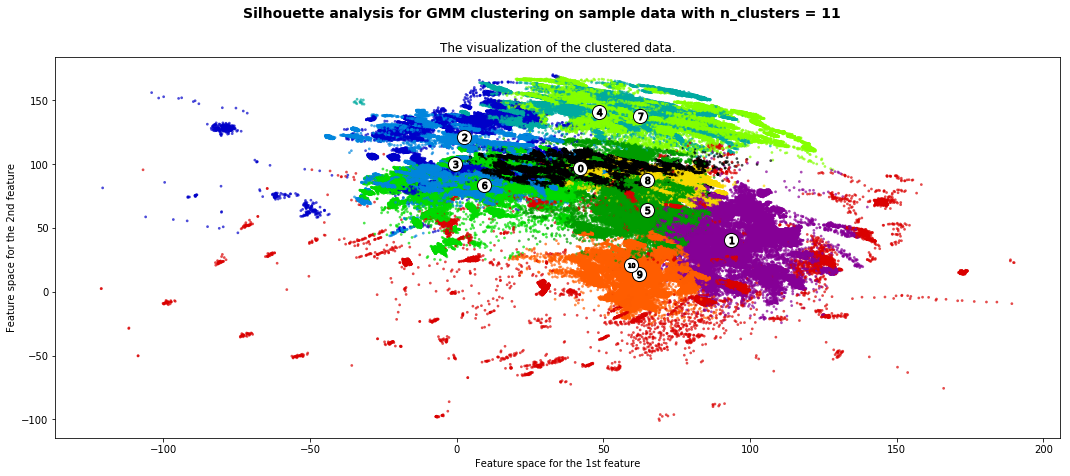

In [40]:
from __future__ import print_function

from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)


# Split into X Features & Y Training
df2b = df2.copy()
#df2b = df2b[df2b.User > 12 ] #User 13 & 14
#df3 = df2b[['X','Y','Z']]
#X = df3.values[:,]
df3s = df2b[['Sensor']]
#y = df3s.values[:,] 
 
X = gmm_X.values[:,]
y = df3s[['Sensor']]
clusterer = gmm
sample_size=50000 
random_state=123456789
silhouette_avg = gmm_sil

range_n_clusters = [11]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax2) = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    #ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    #ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a rsample_size=50andom generator
    # seed of 10 for reproducibility.
    clusterer = clusterer #gmm(n_clusters=11, init='k-means++',random_state=1)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = gmm_sil #silhouette_score(X, cluster_labels, sample_size=sample_size, random_state=random_state)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    #ax1.set_title("The silhouette plot for the various clusters.")
    #ax1.set_xlabel("The silhouette coefficient values")
    #ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    #ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    #ax1.set_yticks([])  # Clear the yaxis labels / ticks
    #ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.means_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for GMM clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

### GMM Clustering

First, we will plot our GMM produced clusters using the original, unoptimized clustering fit to establish a baseline of what unoptimized GMM clustering looks like for our data in 3-dimensional space.

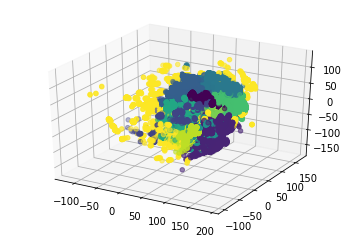

In [41]:
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = np.linspace(0, 15, 1000)
xline = np.sin(zline)
yline = np.cos(zline)
ax.plot3D(xline, yline, zline, 'gray')

# Data for three-dimensional scattered points
zdata = gmm_X['Z'].astype(float)
xdata = gmm_X['X'].astype(float)
ydata = gmm_X['Y'].astype(float)
_ = ax.scatter3D(gmm_X['X'], gmm_X['Y'], gmm_X['Z'], c=gmm_clusters)

In [ ]:
plot_3d(allpts=True, clusters=gmm_clusters)

We plot the basic GMM clusters above, both as a static image consisting of all points (more than 600,000) and an interactive plot that is sampled as 20,000 random points from the dataset color-coded by cluster. This sampling was necessary to produce an interactive 3D plot since a higher number of points rendered much too slowly in the browser. We believe that an interactive plot like this is crucial for modeling spatial 3D data effectively. From these visuals, we can see that there does appear to be decent clustering.

From the data description, we know that there are 2 sensors on each finger and 3 sensors on the thumb. We also know that there are several positions in which multiple (sometimes more than half) of the sensors are obscured from view and not recorded. Therefore, this clustering makes sense from a logical perspective, but it could likely still be improved.

Another interesting comparison is the distribution of clusters as defined by GMM. While we do not know from the raw data which sensors correspond to which point on the glove, we do know that in a majority of recorded instances there are sensors that were unable to be recorded. It would be interesting to note if this clustering algorithm created clusters of varying sizes, which might be indicative of an uneven distribution of which sensors were not recorded most or least often.

Next, we take a look at how the clustering has distributed our dataset with this initial GMM approach:

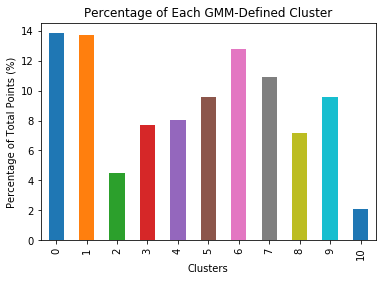

In [42]:
# Create a new dataframe with the clusters defined as a new variable
df_gmm = gmm_X.copy()
df_gmm['Clusters'] = gmm_clusters

# Count the number of instances in each cluster and convert to a percentage of the total
cluster_pcts = df_gmm.groupby('Clusters').count()['X'] / len(gmm_X) * 100

# Plot the distribution
ax = cluster_pcts.plot(kind='bar', title="Percentage of Each GMM-Defined Cluster")
_ = ax.set_ylabel("Percentage of Total Points (%)")

It is interesting to note from this distribution that there are significantly varying distributions between clusters. If these clusters do in fact coincide with sensors on the glove, this could provide evidence that certain sensors appear more often than others.

This also makes logical sense, since it would be expected that some of the gestures being performed would have obscured at least part of the hand. The distribution shows that from GMM, there are 2 clusters defined that are very scarce in the total (both less than 5%) compared to the rest. This could be accounted for as the 2 sensors present on a finger that is often obscured, such as the pinky finger. Conversely, there are 2 clusters that stand out as about the same percentage as each other (almost 14%) but both significantly higher than most of the other clusters. These cluster could represent sensors on fingers that are needed to perform most of the gestures recorded, so they might show up regardless of user or class.

Next, we will plot our clusters from the final, optimized GMM clustering that we decided on based on silhouette score. 

In [ ]:
plot_3d(allpts=True, clusters=gmm_clusters_final)

Visually, these clusters appear similar to our initial GMM clusters, which is good since those made intuitive sense when viewed. Most clusters now appear to more evenly distributed, which is likely due to our switch from 'full' to 'tied' covariance as these clusters are now all using the same shared covariance matrix, but there do also appear to be 1 or 2 clusters that are much smaller than the others that were not as fragmented in our unoptimized clustering.

We will also re-plot our clustering distribution to see if how that has changed, and if the more even clusters we expect from the visual analysis are truly represented:

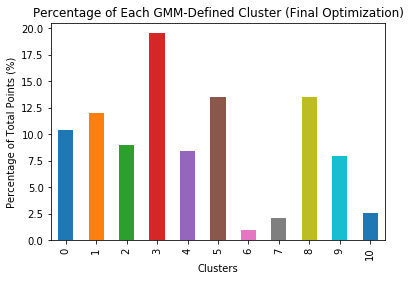

In [43]:
# Create a new dataframe with the clusters defined as a new variable
df_gmm_final = gmm_X_final.copy()
df_gmm_final['Clusters'] = gmm_clusters_final

# Count the number of instances in each cluster and convert to a percentage of the total
cluster_pcts_final = df_gmm_final.groupby('Clusters').count()['X'] / len(gmm_X_final) * 100

# Plot the distribution
ax = cluster_pcts_final.plot(kind='bar', title="Percentage of Each GMM-Defined Cluster (Final Optimization)")
_ = ax.set_ylabel("Percentage of Total Points (%)")

It seems that our cluster distribution changed dramatically, and not exactly in the way that was expected; the optimized clustering did seem to "smooth" out our cluster distribution for those clusters in the middle, but it significantly reduced the size of clusters 6, 7 and 10, with only one significantly large cluster defined (cluster 3).

Even though this runs somewhat counter to our initial logic, this clustering method had a significantly better silhouette score than our initial fit. Furthermore, if we assume that each cluster is representative of one of the 11 possible sensors, it makes sense that there would be multiple sensors with poor representation, since from the initial dataset we know that many captures were missing many sensor position readings.

Finally, we will plot the clusters of the GMM model built with a single random initialization, to get a visual representation of a clustering model with a very poor silhouette score (0.0216).

In [ ]:
plot_3d(allpts=True, clusters=gmm_clusters_rand)

This clustering is in stark contrast to our good GMM clusters. There are 3 large clusters represented and multiple small, insignificant ones. With this as an example of a poor clustering fit, we are more confident in the positive qualities of our previously finalized GMM clustering model.

These visuals allow us to glean important insights about our data and to visualize the effectiveness of our GMM produced clusters.

### KMeanse Clustering

First, we will plot our GMM produced clusters using the default clustering fit (Config 1) to establish a baseline of what GMM clustering looks like for our data in 3-dimensional space.

In [ ]:
# Config 1
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(dpi=50)
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
zdata = kms_X['Z'].astype(float)
xdata = kms_X['X'].astype(float)
ydata = kms_X['Y'].astype(float)
ax.scatter3D(kms_X['X'], kms_X['Y'], kms_X['Z'], c=kms_clusters, s=1)
ax.set_title('Gesture points for X, Y, Z')

In [ ]:
#Config 1
plot_3d(allpts=True, clusters=kms_clusters)

Then against our best one for config 4

In [ ]:
# Config 4
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(dpi=50)
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
zdata = kms_X['Z'].astype(float)
xdata = kms_X['X'].astype(float)
ydata = kms_X['Y'].astype(float)
ax.scatter3D(kms_X['X'], kms_X['Y'], kms_X['Z'], c=kms_clusters4, s=1)
ax.set_title('Gesture points for X, Y, Z')

In [ ]:
#Config 4
plot_3d(allpts=True, clusters=kms_clusters4)

As per points distribution between the different configuraitons:

In [ ]:
#Config 1
# Create a new dataframe with the clusters defined as a new variable
df_kms = kms_X.copy()
df_kms['Clusters'] = kms_clusters

# Count the number of instances in each cluster and convert to a percentage of the total
cluster_pcts = df_kms.groupby('Clusters').count()['X'] / len(kms_X) * 100

# Plot the distribution
ax = cluster_pcts.plot(kind='bar', title="Percentage of Each KMeans (Config 1)-Defined Cluster")
_ = ax.set_ylabel("Percentage of Total Points (%)")

In [ ]:
#Config 2
# Create a new dataframe with the clusters defined as a new variable
df_kms = kms_X.copy()
df_kms['Clusters'] = kms_clusters2

# Count the number of instances in each cluster and convert to a percentage of the total
cluster_pcts = df_kms.groupby('Clusters').count()['X'] / len(kms_X) * 100

# Plot the distribution
ax = cluster_pcts.plot(kind='bar', title="Percentage of Each KMeans (Config 2)-Defined Cluster")
_ = ax.set_ylabel("Percentage of Total Points (%)")

In [ ]:
#Config 3
# Create a new dataframe with the clusters defined as a new variable
df_kms = kms_X.copy()
df_kms['Clusters'] = kms_clusters3

# Count the number of instances in each cluster and convert to a percentage of the total
cluster_pcts = df_kms.groupby('Clusters').count()['X'] / len(kms_X) * 100

# Plot the distribution
ax = cluster_pcts.plot(kind='bar', title="Percentage of Each KMeans (Config 3)-Defined Cluster")
_ = ax.set_ylabel("Percentage of Total Points (%)")

In [ ]:
#Config 4
# Create a new dataframe with the clusters defined as a new variable
df_kms = kms_X.copy()
df_kms['Clusters'] = kms_clusters4

# Count the number of instances in each cluster and convert to a percentage of the total
cluster_pcts = df_kms.groupby('Clusters').count()['X'] / len(kms_X) * 100

# Plot the distribution
ax = cluster_pcts.plot(kind='bar', title="Percentage of Each KMeans (Config 4)-Defined Cluster")
_ = ax.set_ylabel("Percentage of Total Points (%)")

In [ ]:
#Config 5
# Create a new dataframe with the clusters defined as a new variable
df_kms = kms_X.copy()
df_kms['Clusters'] = kms_clusters5

# Count the number of instances in each cluster and convert to a percentage of the total
cluster_pcts = df_kms.groupby('Clusters').count()['X'] / len(kms_X) * 100

# Plot the distribution
ax = cluster_pcts.plot(kind='bar', title="Percentage of Each KMeans (Config 5)-Defined Cluster")
_ = ax.set_ylabel("Percentage of Total Points (%)")

In [ ]:
#Config 6
# Create a new dataframe with the clusters defined as a new variable
df_kms = kms_X.copy()
df_kms['Clusters'] = kms_clusters6

# Count the number of instances in each cluster and convert to a percentage of the total
cluster_pcts = df_kms.groupby('Clusters').count()['X'] / len(kms_X) * 100

# Plot the distribution
ax = cluster_pcts.plot(kind='bar', title="Percentage of Each KMeans (Config 6)-Defined Cluster")
_ = ax.set_ylabel("Percentage of Total Points (%)")

The defauls or config 1 was relitively smooth in the middle 9 categories but had almost nothing for the first and last.  Configs 2, 4, and 6 had a very similar looking likely due to it being random and similar toleranc.  Config 3 and 5 look almost the same, though the parameters were very differnet.  Maybe this is because a low tolerance for 'random' is similar to a default or high tolerance for 'k-means++'

# Modeling and Evaluation 4

| Clustering method | y        | z              | Comment                                 |
| ----------------- | ---------| -------------- | --------------------------------------- |
| Kmeans            | value  | value            | Classifier for hand gesture ma          |
| GMM               | value  | value            | Classifier for hand gesture ma          |
| Class             | value  | value            | Classifier for hand gesture ma          |
| Class             | value  | value            | Classifier for hand gesture ma          |

Examination of our various clustering models shows somewhat below the hoped-for results. While we were able to create clusters for our dataset that appear reasonable, there is clearly too much variation in the data for the selected clustering algorithms to consistently create a clustered region that could be usable for most motion capture-oriented applications.

# Deployment 

Motion capture requires a great deal of precision for users to feel immersion or a useful effect, so a very low precision cluster indicated by silhouette scores in the .3's as mentioned in the Modeling and Evaluation 4 section, indicates that other modeling techniques would need to be utilized, likely in conjunction with some of the clustering work performed in this effort.

Other than a cursory reference to common areas of sensor location, these results will not have an effective business application on their own and we would strongly advise against deployment until more mechanisms are added to create more significant performance results. This would likely only be achieved by using clustering in conjunction with other techniques such as using a random forest model to predict location based on known gestures or known behavior by supplementing this dataset.

<br>

# Exceptional Work

#### Attempt to Center Data
The data in this dataset is taken with slightly differing points serving as the origin for each coordinate set. Due to this fact, we attempted to center our data somewhat by subtracting the minimum x,y,&z coordinate value for each coordinate set to effectively 0 each record so a similar origin could be created. 

We had hoped that this would allow us to reduce variance and keep points on a more even plane. Unfortunately, the centering method was not successful and we ended up with a lower silhouette score than was obtained otherwise. 

Nevertheless, we believe that it was incredibly important to the data cleaning process to rule out any potential for improving our dataset prior to clustering, and this method allowed us to rule out one potential change that could have been made to the dataset.

#### Data centering
This section searches for minimum x,y,z coordinate values and zeroes them and adjusts each coordinate accordingly to reduce variation relative to starting hand position. First we will spit the data into new dataframes for the x,y,z coordinates

In [44]:
#creates new sub dataframes for x y and z coordinates
dfx=df[['X0','X1','X2','X3','X4','X5','X6','X7','X8','X9','X10']].copy()
dfy=df[['Y0','Y1','Y2','Y3','Y4','Y5','Y6','Y7','Y8','Y9','Y10']].copy()
dfz=df[['Z0','Z1','Z2','Z3','Z4','Z5','Z6','Z7','Z8','Z9','Z10']].copy()

Next We will calculate the minimum value for each coordinate's data frame and store it in the respective dataframe. We can then iterate through each column and subtract the minimum value from each respective column to 0 our data.

In [45]:
#calculates min value
dfx['xmin']=dfx.min(axis=1)
dfy['ymin']=dfy.min(axis=1)
dfz['zmin']=dfz.min(axis=1)

In [46]:
###takes minimum and subtracts form all
for a in range(11): 
    dfx['X%d' % a] = dfx['X%d' % a] - dfx['xmin']
    
for b in range(11): 
    dfy['Y%d' % b] = dfy['Y%d' % b] - dfy['ymin']
    
for c in range(11): 
    dfz['Z%d' % c] = dfz['Z%d' % c] - dfz['zmin']    

Next, we will remove the calculated fields and merge our new dataframes together into a new central dataframe. Finally we will reorder the columns to be consistent with the original format.

In [47]:
#remove the calculated min values for merging
del dfx['xmin']
del dfy['ymin']
del dfz['zmin']

In [48]:
#create mini dataframe and then concatenate the transformed dataframes
dfmini = df.iloc[:,0:2].copy()
dfnew= pd.concat([dfmini,dfx, dfy,dfz], axis=1)

In [49]:
#reorder the columns
dfnew = dfnew[['Class','User', 'X0','Y0','Z0','X1','Y1','Z1','X2','Y2','Z2','X3','Y3','Z3','X4','Y4','Z4','X5','Y5','Z5',
               'X6','Y6','Z6','X7','Y7','Z7','X8','Y8','Z8','X9','Y9','Z9','X10','Y10','Z10']]

Unfortunately testing showed a much worse clustering score via silhouette scoring at nearly .06 in our analysis and examination showed more work would need to be examined to make this possible. This is likely due to the fact that our dataset post transformation was heavily overlapped at the axis points for zeroing which took away some of the natural variation that should be present and effectively overcorrected for the problem we were experiencing.

We do feel the approach however, could be worth investigating further to greater improve model performance.

As an area of future work, attempting to account for variance in how far the min value was away from the other points could be utilized to help center and keep the data from pooling at axis points lowering our ability to cluster. This may be a matter of attempting to normalize and center values while examining min max values where hand position clearly started outside of a typical origin location.



<br>

### Additional 3D plots
In this section we performed further 3d plotting to improve our understanding of the dataset.

In [50]:
from mpl_toolkits import mplot3d

In [51]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [52]:
#1=Fist(with thumb out), 
#2=Stop(hand flat), 
#3=Point1(point with pointer finger), 
#4=Point2(point with pointer and middle fingers), 
#5=Grab(fingers curled as if to grab). 

#filter certain users for plotting below
df_user6 = df[df.User == 6][df.Class == 2]
df_user14 = df[df.User == 14][df.Class == 1]
df_user5 = df[df.User == 5][df.Class == 4]
df_user8 = df[df.User == 8][df.Class == 3]

#One row in data table - represnts on set of data points
df_row12000 = df[11999:12000][df.Class == 5]

# feature categories
X_features = ['X0','X1','X2','X3','X4','X5','X6','X7','X8','X9','X10']
Y_features = ['Y0','Y1','Y2','Y3','Y4','Y5','Y6','Y7','Y8','Y9','Y10']
Z_features = ['Z0','Z1','Z2','Z3','Z4','Z5','Z6','Z7','Z8','Z9','Z10']

##### One record plotted in 3D show Class 5 (Grab Gestures)

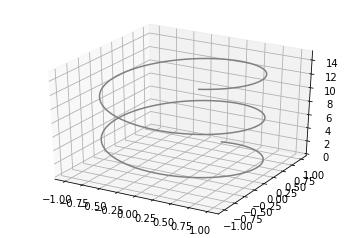

In [53]:
#one set of markers
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = np.linspace(0, 15, 1000)
xline = np.sin(zline)
yline = np.cos(zline)
ax.plot3D(xline, yline, zline, 'gray')

# Data for three-dimensional scattered points
zdata = df_row12000[Z_features].astype(float)
xdata = df_row12000[X_features].astype(float)
ydata = df_row12000[Y_features].astype(float)
ax.scatter3D(xdata, ydata, zdata);

##### All User 6's records plotted in 3D with Posture 3 (Stop sign)

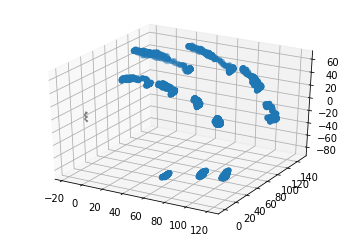

In [54]:
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = np.linspace(0, 15, 1000)
xline = np.sin(zline)
yline = np.cos(zline)
ax.plot3D(xline, yline, zline, 'gray')

# Data for three-dimensional scattered points
zdata = df_user6[Z_features].astype(float)
xdata = df_user6[X_features].astype(float)
ydata = df_user6[Y_features].astype(float)
ax.scatter3D(xdata, ydata, zdata);

##### All User 14's records plotted in 3D with Class 1 (Fist Gesture)

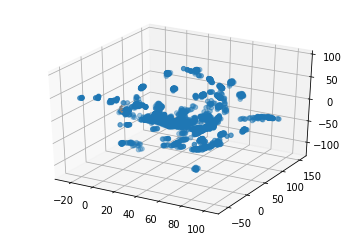

In [55]:
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = np.linspace(0, 15, 1000)
xline = np.sin(zline)
yline = np.cos(zline)
ax.plot3D(xline, yline, zline, 'gray')

# Data for three-dimensional scattered points
zdata = df_user14[Z_features].astype(float)
xdata = df_user14[X_features].astype(float)
ydata = df_user14[Y_features].astype(float)
ax.scatter3D(xdata, ydata, zdata);

##### All User 8's records plotted in 3D with Class 3 (point with pointer finger Gesture)

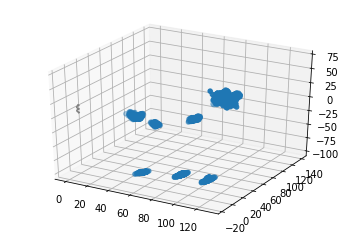

In [56]:
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = np.linspace(0, 15, 1000)
xline = np.sin(zline)
yline = np.cos(zline)
ax.plot3D(xline, yline, zline, 'gray')

# Data for three-dimensional scattered points
zdata = df_user8[Z_features].astype(float)
xdata = df_user8[X_features].astype(float)
ydata = df_user8[Y_features].astype(float)
ax.scatter3D(xdata, ydata, zdata);

##### All User 5's records plotted in 3D with Class 5 (Grab Gesture)

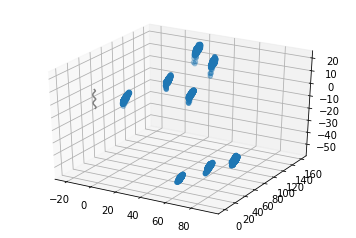

In [57]:
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = np.linspace(0, 15, 1000)
xline = np.sin(zline)
yline = np.cos(zline)
ax.plot3D(xline, yline, zline, 'gray')

# Data for three-dimensional scattered points
zdata = df_user5[Z_features].astype(float)
xdata = df_user5[X_features].astype(float)
ydata = df_user5[Y_features].astype(float)
ax.scatter3D(xdata, ydata, zdata);

##### All User 5's records plotted in 3D in a Wireframe show Class 2 (Stop Gesture)

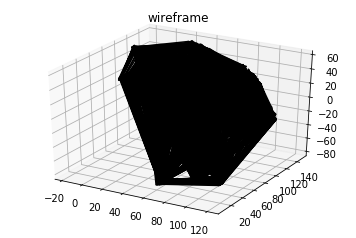

In [58]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_wireframe(df_user6[X_features], df_user6[Y_features], df_user6[Z_features], color='black')
ax.set_title('wireframe');


### Silhouette Work (save for putting plots in later)

##### https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

Silhouette analysis can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. This measure has a range of [-1, 1].

Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.

In this example the silhouette analysis is used to choose an optimal value for n_clusters. The silhouette plot shows that the n_clusters value of 3, 5 and 6 are a bad pick for the given data due to the presence of clusters with below average silhouette scores and also due to wide fluctuations in the size of the silhouette plots. Silhouette analysis is more ambivalent in deciding between 2 and 4.

Also from the thickness of the silhouette plot the cluster size can be visualized. The silhouette plot for cluster 0 when n_clusters is equal to 2, is bigger in size owing to the grouping of the 3 sub clusters into one big cluster. However when the n_clusters is equal to 4, all the plots are more or less of similar thickness and hence are of similar sizes as can be also verified from the labelled scatter plot on the right.

In [ ]:
from __future__ import print_function

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)


# Split into X Features & Y Training
df2b = df2.copy()
df2b = df2b[df2b.User > 12 ] #User 13 & 14
df3 = df2b[['X','Y','Z']]
X = df3.values[:,]
df3s = df2b[['Sensor']]
y = df3s.values[:,] 
 

# Not done for now
range_n_clusters = []

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=11, init='k-means++',random_state=1)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

#plt.show()